In [1]:
import campyros as pyro
import csv
import time
import numpy as np
import pandas as pd

In [2]:
'''Import motor data to use for the mass model'''
motor_csv = pd.read_csv('novus_sim_6.1/motor_out.csv')

time_array = motor_csv['Time']
smass_array = motor_csv['Solid Fuel Mass (kg)']
S_DEN = motor_csv['Solid Fuel Density (kg/m^3)'][0]
S_L = motor_csv['Solid Fuel Length (m)'][0]
S_ROUT = motor_csv['Solid Fuel Outer Diameter (m)'][0]
vmass_array =  motor_csv['Vapour Mass (kg)']
vden_array = motor_csv['Vapour Density (kg/m^3)']
lmass_array = motor_csv['Liquid Mass (kg)']
lden_array = motor_csv['Liquid Density (kg/m^3)']

In [3]:
'''Rocket parameters'''
DRY_MASS = 60                       #Rocket dry mass (kg)
ROCKET_L = 6.529                    #Rocket length (m)
ROCKET_R = 98.5e-3                  #Rocket radius (m)
ROCKET_T = 1e-2                     #Rocket wall thickness (m) - used when approximating the rocket airframe as a thin walled cylinder
POS_TANK_BOTTOM = 4.456             #Distance between the nose tip and the bottom of the nitrous tank (m)
POS_SOLIDFUEL_BOTTOM = 4.856 + S_L  #Distance between the nose tip and bottom of the solid fuel grain (m)
REF_AREA = 0.0305128422             #Reference area for aerodynamic coefficients (m^2)

In [5]:
'''Set up aerodynamic properties'''
#Get approximate values for the rotational damping coefficients
C_DAMP_PITCH = pyro.pitch_damping_coefficient(ROCKET_L, ROCKET_R, fin_number = 4, area_per_fin = 0.07369928)
C_DAMP_ROLL = 0

#Import drag coefficients from RASAero II
aero_data = pyro.AeroData.from_rasaero("data/Martlet4RASAeroII.CSV", REF_AREA, C_DAMP_PITCH, C_DAMP_ROLL)
#aero_data.show_plot()   #Show plots of how the program interpreted the data, so you can visually check if it's correct

In [6]:
'''Set up the mass model'''
mass_model = pyro.MassModel()
mass_model.add_hollowcylinder(DRY_MASS, ROCKET_R, ROCKET_R - ROCKET_T, ROCKET_L, ROCKET_L/2)
mass_model.add_liquidtank(lmass_array, lden_array, time_array, ROCKET_R, POS_TANK_BOTTOM, vmass_array, vden_array)
mass_model.add_solidfuel(smass_array, time_array, S_DEN, S_ROUT, S_L, POS_SOLIDFUEL_BOTTOM)

In [13]:
'''Create the other objects needed to initialise the Rocket object'''
pulsar = pyro.Motor.from_novus('novus_sim_6.1/motor_out.csv', pos = ROCKET_L)

In [14]:
launch_site = pyro.LaunchSite(
    rail_length=5,
    rail_yaw=0,
    rail_pitch=0,
    alt=10,
    longi=0.1,
    lat=52.1,
    variable_wind=True,
    cache_Wind=True
)

In [15]:
parachute = pyro.Parachute(main_s=13.9,
                                 main_c_d=0.78,
                                 drogue_s=1.13,
                                 drogue_c_d=0.78,
                                 main_alt=1000,
                                 attach_distance=0)

In [16]:
martlet4 = pyro.Rocket(mass_model, 
                            pulsar, 
                            aero_data, 
                            launch_site, 
                            h=0.05, 
                            variable=True, 
                            alt_poll_interval=1, 
                            parachute=parachute)

In [18]:
t=time.time()
simulation_output = martlet4.run(debug=True,to_json="data/trajectory.json")
print(f"Simulation run time: {time.time()-t:.2f} s")

Running simulation
t=0.01 s alt=7.65 km (h=0.012381095176601492 s). Step number 0
t=17.42 s alt=24.94 km (h=0.19202113298397105 s). Step number 100
Burnout at t=24.79 s 
t=32.51 s alt=47.29 km (h=5.47865912558159 s). Step number 200
Parachute deployed at 154.15 km at 201.87 s
t=498.89 s alt=6.22 km (h=7.531497546372429 s). Step number 300


/Users/jago/Documents/Projects/6DOF-Trajectory-Simulation/trajectory/main.py:737: RuntimeWarning:overflow encountered in multiply


Exported JSON data to 'data/trajectory.json'
Simulation run time: 29.25 s


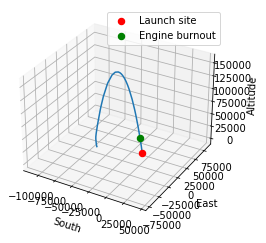

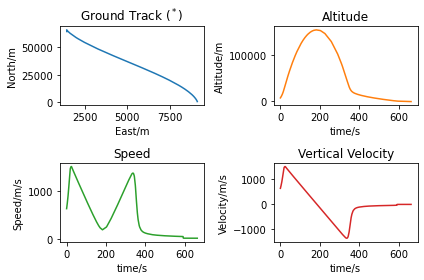

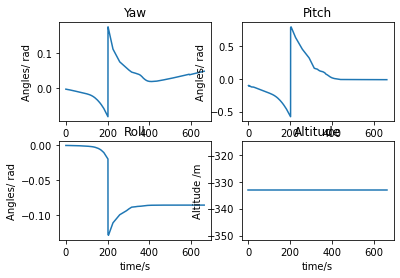

In [19]:
'''Example of how you can import data from a .csv file'''
imported_data = pyro.from_json("data/trajectory.json")

'''Plot the results'''
pyro.plot_launch_trajectory_3d(imported_data, martlet4, show_orientation=False) #Could have also used simulation_output instead of imported_data
pyro.plot_altitude_time(imported_data, martlet4)
pyro.plot_ypr(imported_data, martlet4)
#trajectory.animate_orientation(imported_data)
